In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree
from scipy.linalg import sqrtm

In [2]:
np.random.seed(13)
p = 3
n = 2000
# locations of observations (1x1 square domain)
s = np.random.rand(n,2)

In [3]:
def matern_correlation(distances, nu, length_scale):
    """
    Calculates the Matern correlation function.

    Args:
        distances (np.ndarray): A 1D array of distances between points.
        nu (float): The smoothness parameter of the Matern kernel.
                    Common values are 0.5, 1.5, 2.5, or infinity (for RBF kernel).
        length_scale (float): The characteristic length scale of the correlation.

    Returns:
        np.ndarray: A 1D array of Matern correlation values.
    """
    if nu == 0.5:
        # Exponential kernel (Matern with nu=0.5)
        return np.exp(-distances / length_scale)
    elif nu == 1.5:
        # Matern with nu=1.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(3) * scaled_dist) * np.exp(-np.sqrt(3) * scaled_dist)
    elif nu == 2.5:
        # Matern with nu=2.5
        scaled_dist = distances / length_scale
        return (1 + np.sqrt(5) * scaled_dist + 5/3 * scaled_dist**2) * np.exp(-np.sqrt(5) * scaled_dist)
    elif np.isinf(nu):
        # Radial Basis Function (RBF) or Squared Exponential kernel (Matern with nu=infinity)
        return np.exp(-0.5 * (distances / length_scale)**2)
    else:
        # General Matern kernel (requires special functions from scipy.special)
        from scipy.special import kv, gamma
        scaled_dist = distances / length_scale
        # Handle the case where scaled_dist is zero to avoid division by zero in kv
        # and ensure correlation is 1 at zero distance.
        correlation = np.zeros_like(scaled_dist)
        non_zero_indices = scaled_dist > 1e-10 # Small epsilon to avoid exact zero
        
        correlation[non_zero_indices] = (2**(1-nu) / gamma(nu)) * \
                                        (np.sqrt(2*nu) * scaled_dist[non_zero_indices])**nu * \
                                        kv(nu, np.sqrt(2*nu) * scaled_dist[non_zero_indices])
        correlation[~non_zero_indices] = 1.0 # Correlation is 1 at zero distance
        return correlation

In [4]:
# Calculate pairwise distances between points
distances = pdist(s, 'euclidean') # Calculates distances in a condensed form
D = squareform(distances) # Converts to a square matrix

K1 = matern_correlation(D, 6, 1.2)
K2 = matern_correlation(D, 1, 1.5)
K3 = matern_correlation(D, 0.25, 1)
z = np.stack([
    np.random.multivariate_normal(np.zeros(n), K1),
    np.random.multivariate_normal(np.zeros(n), K2),
    np.random.multivariate_normal(np.zeros(n), K3)])

# center the data:
#z = z - z.mean(axis=1)[:, np.newaxis]

In [5]:
# mixing matrix
O = np.random.normal(size=(p,p))
x = O @ z

In [25]:
O

array([[-0.07755485, -1.18541645,  0.00981212],
       [ 0.69380512, -0.99664282,  1.84832042],
       [ 0.30270117,  0.22891315,  0.3938764 ]])

In [26]:
np.savetxt('mixture.csv', x, delimiter=',') 

In [6]:
def whiten(x):
    # center the data:
    x = x - x.mean(axis=1)[:, np.newaxis]
    S = x @ x.T / (x.shape[1] - 1)
    L_s, Q_s = np.linalg.eigh(S)
    W = Q_s @ np.diag(1 / (L_s)**0.5) @ Q_s.T
    return W @ x, W

In [7]:
xt, W = whiten(x)

In [8]:
# xt is whitened
np.cov(xt)

array([[ 1.00000000e+00,  1.40269098e-14, -7.11484676e-14],
       [ 1.40269098e-14,  1.00000000e+00,  3.77984565e-14],
       [-7.11484676e-14,  3.77984565e-14,  1.00000000e+00]])

In [9]:
def calculate_local_covariance(points, radius, variables):
    """
    Calculates the covariance matrix for points within a certain radius for each point.

    Args:
        points (np.ndarray): A NumPy array of shape (N, D) where N is the number of
                             points and D is the dimension (e.g., 3 for 3D points).
        radius (float): The radius within which to search for neighbors.
        variables (np.ndarray): a NumPy array of shape (N, P) where P is the dimension
                            of the variables

    Returns:
        np.ndarray: PxP matrix of the covariance
    """
    # Build a KD-Tree for efficient spatial searching
    tree = KDTree(points)
    
    # List to store the covariance matrix for each point
    covariance_matrix = np.zeros((variables.shape[1], variables.shape[1]))
    
    # Iterate over each point
    for i, query_point in enumerate(points):
        # Find indices of points within the specified radius
        neighbor_indices = tree.query_ball_point(query_point, radius)
        #print(query_point, neighbor_indices)
        # Select the neighboring points
        neighbors = variables[neighbor_indices]
        
        covariance_matrix += np.einsum('j, ik -> jk', variables[i], neighbors)
            
    return covariance_matrix / variables.shape[0]

In [10]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.35, xt.T)
M005 = calculate_local_covariance(s, 0.2, xt.T)
M0025 = calculate_local_covariance(s, 0.05, xt.T)
M001 = calculate_local_covariance(s, 0.01, xt.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [11]:
M.shape

(3, 4, 3)

In [12]:
def H(g, S):
    # shape of S (p,k,p)
    return np.tensordot(g, S, axes=([0],[0])) @ g @ (S @ g).T

In [13]:
G = np.eye(p)
for i in range(5000):
    for j in range(p):
        G[j,:] = H(G[j,:], M)
    # orthogonalize
    U, Sigma, V = np.linalg.svd(G)
    G = U @ V.T

In [14]:
# off-diagonals are minimized
G @ M01 @ G.T, G @ M005 @ G.T, G @ M0025 @ G.T, G @ M001 @ G.T

(array([[131.8706183 ,  24.47881699,  16.96874888],
        [ 24.47881699, 293.33545115, -59.85968607],
        [ 16.96874888, -59.85968607, 287.31660243]]),
 array([[ 87.2464091 ,  12.25348183,   4.96993803],
        [ 12.25348183, 149.95391146, -17.08550601],
        [  4.96993803, -17.08550601, 161.35087141]]),
 array([[12.30139033,  0.57157041,  0.0830672 ],
        [ 0.57157041, 14.00157775, -0.71928426],
        [ 0.0830672 , -0.71928426, 15.37037995]]),
 array([[ 1.50761234, -0.02502168, -0.00512845],
        [-0.02502168,  1.64304397,  0.0017425 ],
        [-0.00512845,  0.0017425 ,  1.61015207]]))

In [15]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.075, x.T)
M005 = calculate_local_covariance(s, 0.2, x.T)
M0025 = calculate_local_covariance(s, 0.05, x.T)
M001 = calculate_local_covariance(s, 0.01, x.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [16]:
G @ W @ M01 @ W @ G.T, G @ W @ M005 @ W @ G.T, G @ W @ M0025 @ W @ G.T, G @ W @ M001 @ W @ G.T

(array([[ 61.72126496, 127.35072611, 169.6573831 ],
        [127.35072611, 443.91360124, 557.14478738],
        [169.6573831 , 557.14478738, 785.24673314]]),
 array([[ 346.15648684,  829.56582151, 1103.41505809],
        [ 829.56582151, 2718.31739756, 3436.7055168 ],
        [1103.41505809, 3436.7055168 , 4805.47739522]]),
 array([[ 29.89410679,  59.07827193,  78.93337919],
        [ 59.07827193, 208.53934597, 261.49927354],
        [ 78.93337919, 261.49927354, 368.77462326]]),
 array([[ 3.23191738,  5.79556203,  7.81134678],
        [ 5.79556203, 21.29100052, 26.38666691],
        [ 7.81134678, 26.38666691, 37.04022857]]))

In [17]:
# G is orthogonal
G @ G.T

array([[ 1.00000000e+00, -3.34466924e-16,  2.72436497e-16],
       [-3.34466924e-16,  1.00000000e+00, -1.87761860e-16],
       [ 2.72436497e-16, -1.87761860e-16,  1.00000000e+00]])

In [18]:
from scipy.optimize import linear_sum_assignment

def MDI(G):
    Gt = G**2 / (np.linalg.norm(G, axis=1)**2)[:, np.newaxis]
    cost = np.ones_like(Gt) - 2*Gt - (Gt**2).sum(axis=1)[:, np.newaxis]
    row_ind, col_ind = linear_sum_assignment(cost, maximize=False)
    perm = np.argsort(col_ind)
    return (G.shape[0] - (Gt[row_ind, col_ind]).sum())**0.5 / (G.shape[0] - 1)**0.5

In [19]:
MDI(G @ W @ O)

np.float64(0.5131063929538328)

In [20]:
(G @ W) @ O

array([[ 0.83570164, -0.99659635, -1.25902966],
       [-5.54899044, -0.34689848,  0.24733744],
       [-0.0558815 , -3.42932841,  0.2224503 ]])

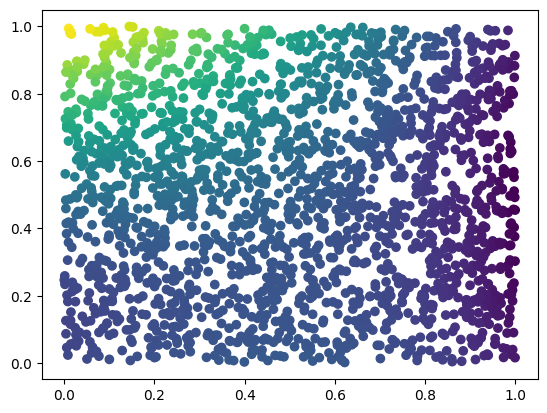

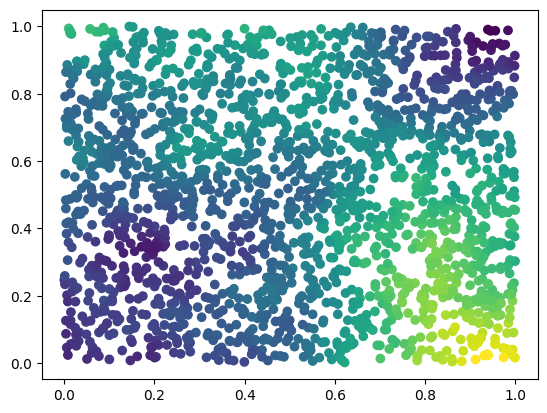

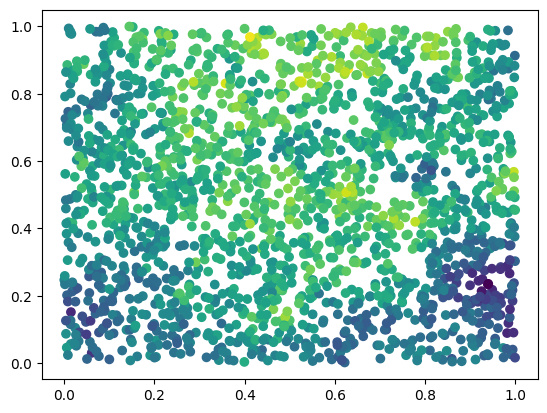

In [21]:
import matplotlib.pyplot as plt
plt.scatter(s.T[0], s.T[1], c = z[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[2])
plt.show()

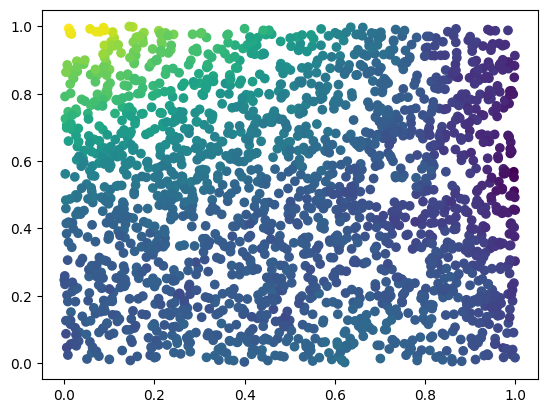

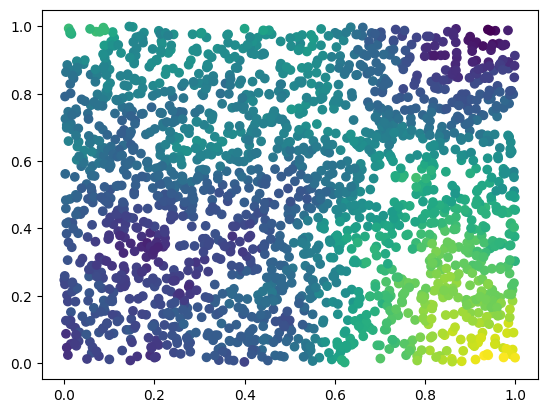

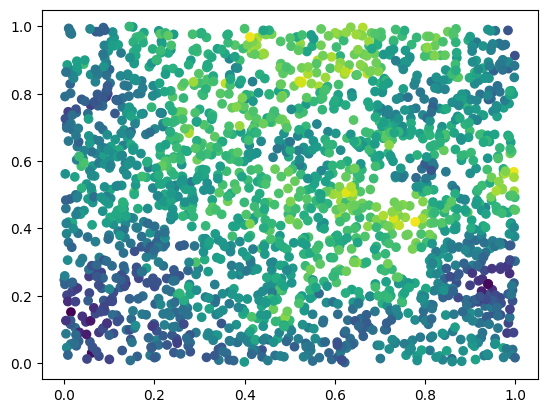

In [23]:
zt = G @ W @ x
plt.scatter(s.T[0], s.T[1], c = -1*zt[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = -1*zt[2])
plt.show()
plt.scatter(s.T[0], s.T[1], c = -1*zt[0])
plt.show()

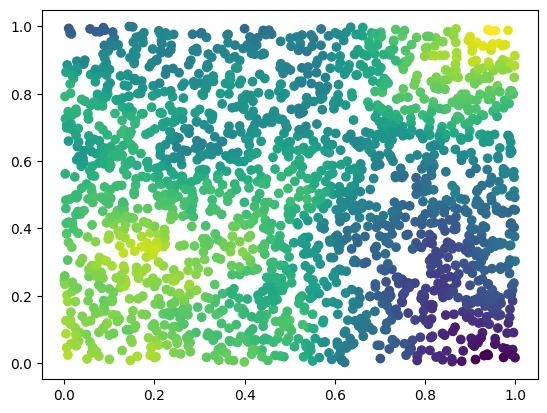

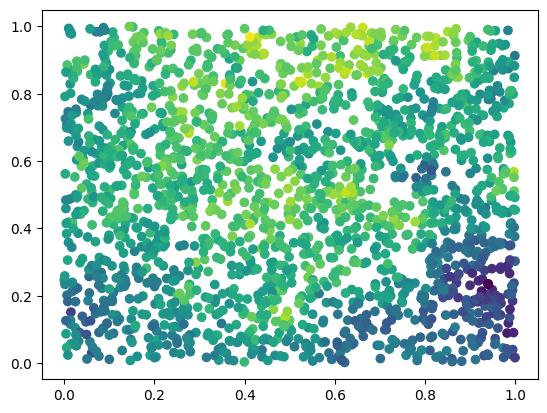

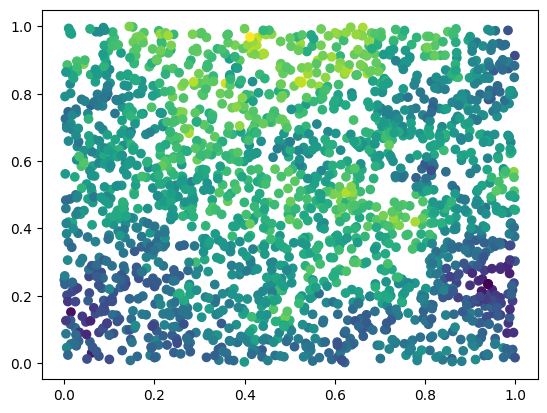

In [24]:
plt.scatter(s.T[0], s.T[1], c = x[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = x[2])
plt.show()